# Init

In [1]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=32'

In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import argparse
import os
import time

import jax
import jax.numpy as jnp
import jax.random as jnr
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import vmap
from jax.scipy.optimize import minimize
from numpyro import handlers
from numpyro.diagnostics import effective_sample_size
from numpyro.handlers import block, condition, seed, trace
from numpyro.infer import MCMC, NUTS
from numpyro.infer.util import log_density, log_likelihood

from muse_inference.jax import JaxMuseProblem, MuseResult, ScoreAndMAP

# the non-linearity we use in our neural network
def nonlin(x):
    return jnp.tanh(x)

/home/zramzi/workspace/muse_inference/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
np.set_printoptions(precision=3, suppress=True)

In [5]:
jax.config.update('jax_enable_x64', True)
# jax.config.update('jax_platform_name', 'gpu')
jax.config.update('jax_platform_name', 'cpu')
# jax.config.update('jax_disable_jit', True)

In [6]:
ncalls = 0

def register_call():
    global ncalls
    ncalls += 1

def count_calls(f):
    global ncalls
    ncalls = 0
    ans = f()
    return ncalls, ans

In [7]:
factor_speedup = {}
chains = {}
results = {}

# Bayesian Neural Network

Slightly modified version of https://num.pyro.ai/en/stable/examples/bnn.html

## Model

In [8]:
# a two-layer bayesian neural network with computational flow
# given by D_X => D_H => D_H => D_Y where D_H is the number of
# hidden units. (note we indicate tensor dimensions in the comments)
def model(X, D_H, D_Y=1):
    
    jax.debug.callback(register_call)
    
    σw = numpyro.sample("σw", dist.LogNormal(), sample_shape=(3,))
    
    N, D_X = X.shape

    # sample first layer (we put unit normal priors on all weights)
    w1 = numpyro.sample("w1", dist.Normal(jnp.zeros((D_X, D_H)), σw[0] * jnp.ones((D_X, D_H))))
    assert w1.shape == (D_X, D_H)
    z1 = nonlin(jnp.matmul(X, w1))  # <= first layer of activations
    assert z1.shape == (N, D_H)

    # sample second layer
    w2 = numpyro.sample("w2", dist.Normal(jnp.zeros((D_H, D_H)), σw[1] * jnp.ones((D_H, D_H))))
    assert w2.shape == (D_H, D_H)
    z2 = nonlin(jnp.matmul(z1, w2))  # <= second layer of activations
    assert z2.shape == (N, D_H)

    # sample final layer of weights and neural network output
    w3 = numpyro.sample("w3", dist.Normal(jnp.zeros((D_H, D_Y)), σw[2] * jnp.ones((D_H, D_Y))))
    assert w3.shape == (D_H, D_Y)
    z3 = jnp.matmul(z2, w3)  # <= output of the neural network
    assert z3.shape == (N, D_Y)

    # we put a prior on the observation noise
    prec_obs = numpyro.sample("prec_obs", dist.Gamma(3.0, 1.0))
    sigma_obs = 1.0 / jnp.sqrt(prec_obs)

    # observe data
    with numpyro.plate("data", N):
        # note we use to_event(1) because each observation has shape (1,)
        Y = numpyro.sample("Y", dist.Normal(z3, sigma_obs).to_event(1))
        
    return Y, (w1, w2, w3), (prec_obs, σw)

In [9]:
N = 200
# N = 20  # for testing
D_X = 3
D_H = 5
sigma_obs = 0.02
N_test = 500
# N_test = 50  # for testing

In [10]:
X = jnp.linspace(-1, 1, N)
X = jnp.power(X[:, np.newaxis], jnp.arange(D_X))
X_test = jnp.linspace(-1.3, 1.3, N_test)
X_test = jnp.power(X_test[:, np.newaxis], jnp.arange(D_X))

In [11]:
D_Y = 1  # create 1d outputs
np.random.seed(0)
W = 0.5 * np.random.randn(D_X)
Y = jnp.dot(X, W) + 0.5 * jnp.power(0.5 + X[:, 1], 2.0) * jnp.sin(4.0 * X[:, 1])
Y += sigma_obs * np.random.randn(N)
Y = Y[:, np.newaxis]
Y -= jnp.mean(Y)
Y /= jnp.std(Y)

In [12]:
# with seed(rng_seed=0):
#     Y, (w1, w2, w3), (prec_obs, σw) = model(X, D_H)

## NUTS

In [13]:
%%time
mcmc = MCMC(
    NUTS(condition(model, dict(Y=Y))),
    num_warmup = 100,
    num_samples = 500,
    num_chains = 32,
    progress_bar = False,
)
ncalls_chain, _ = count_calls(lambda: mcmc.run(jnr.PRNGKey(0), X, D_H))

CPU times: user 13min 47s, sys: 46.1 s, total: 14min 33s
Wall time: 2min 28s


In [14]:
chains["bnn"] = chain = np.hstack([mcmc.get_samples()["σw"], mcmc.get_samples()["prec_obs"][:,np.newaxis]])

In [15]:
ess = np.concatenate([effective_sample_size(np.array(mcmc.get_samples(True)[k])).ravel() for k in ["σw", "prec_obs"]])
ncalls_chain_per_ess = ncalls_chain / ess
ncalls_chain_per_ess

array([386069.782, 352336.718, 446576.946,  30646.79 ])

In [16]:
# array([386069.782, 352336.718, 446576.946,  30646.79 ])

## MUSE

In [17]:
class NumpyroPPCAProblem(JaxMuseProblem):

    def __init__(self, model, *args, implicit_diff=True, implicit_diff_cgtol=1e-3, use_shine=False, **kwargs):
        super().__init__(implicit_diff=implicit_diff, implicit_diff_cgtol=implicit_diff_cgtol, use_shine=use_shine)
        self.x = model.data["Y"]
        self.args = args
        self.kwargs = kwargs
        self.model_like = model.fn
        self.model_prior = model
        self.model_sample = model.fn
        
    def sample_x_z(self, key, θ):
        (log_σw, log_prec_obs) = θ
        (x, z, _) = seed(condition(self.model_sample, dict(σw=jnp.exp(log_σw), prec_obs=jnp.exp(log_prec_obs))), key)(*self.args, **self.kwargs)
        return (x, z)

    def logLike(self, x, z, θ):
        (w1, w2, w3) = z
        (log_σw, log_prec_obs) = θ
        return log_density(self.model_like, self.args, self.kwargs, dict(Y=x, w1=w1, w2=w2, w3=w3, σw=jnp.exp(log_σw), prec_obs=jnp.exp(log_prec_obs)))[0]

    def z_MAP_guess_from_truth(self, x, z, _):
        return z
    
    def logPrior(self, θ):
        (log_σw, log_prec_obs) = θ
        with seed(rng_seed=0): # dummy seed
            model_trace = trace(condition(self.model_prior, dict(σw=jnp.exp(log_σw), prec_obs=jnp.exp(log_prec_obs)))).get_trace(*self.args, **self.kwargs)
        # jacdet = jnp.sum((log_σw)) + (log_prec_obs)
        return jnp.sum(jnp.array([jnp.sum(model_trace[k]["fn"].log_prob(model_trace[k]["value"])) for k in ["σw", "prec_obs"]])) #+ jacdet

In [18]:
(prob_shine, prob_id, prob_fd) = [
    NumpyroPPCAProblem(condition(model, dict(Y=Y)), X, D_H, implicit_diff=implicit_diff, implicit_diff_cgtol=1e-5, use_shine=use_shine)
    for implicit_diff, use_shine in [
        (True, True),  # SHINE
        (True, False),  # ID
        (False, False),  # FD
    ]
]

/home/zramzi/workspace/muse_inference/venv/lib/python3.9/site-packages/jax/_src/api_util.py:222: SyntaxWarning: Jitted function has invalid argnames {'self'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


In [19]:
def solve(prob, nsims=200):
    z_tol = 1e-1
    result = prob.solve(
        θ_start = (jnp.array([0.,0,0]), 1.), 
        α = 1, 
        z0 = "prior",
        rng = jnr.PRNGKey(0), 
        z_tol = z_tol,
        θ_rtol = 0,
        maxsteps = 15,
        nsims = nsims,
        progress = True,
        get_covariance = False,
        save_MAP_history = False,
    )
    prob.get_J(result=result, progress=True, nsims=nsims, z_tol=z_tol);
    prob.get_H(result=result, progress=True, nsims=nsims, z_tol=z_tol, use_median=True)
    return result

In [20]:
(ncalls_muse_shine, result_shine), (ncalls_muse_id, result_id), (ncalls_muse_fd, result_fd) = [count_calls(lambda: solve(prob)) for prob in [prob_shine, prob_id, prob_fd]]
results["bnn"] = result_id

get_H: 100%|██████████| 200/200 [00:14<00:00, 14.01it/s]


In [21]:
ncalls_muse_per_ess_shine = ncalls_muse_shine / len(result_shine.s_MAP_sims)
ncalls_muse_per_ess_id = ncalls_muse_id / len(result_id.s_MAP_sims)
ncalls_muse_per_ess_fd = ncalls_muse_fd / len(result_fd.s_MAP_sims)

## Sanity check

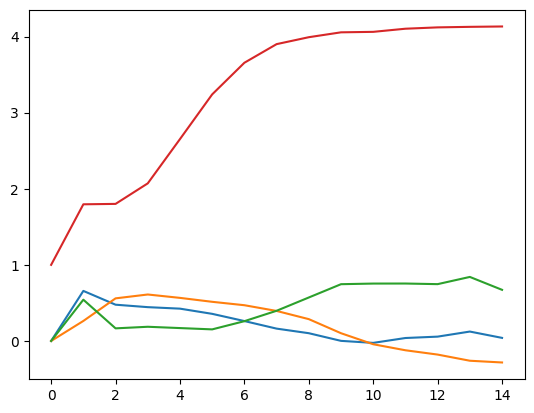

: 

In [ ]:
plot([prob_id.ravel_θ(h["θ"]) for h in result_id.history]);

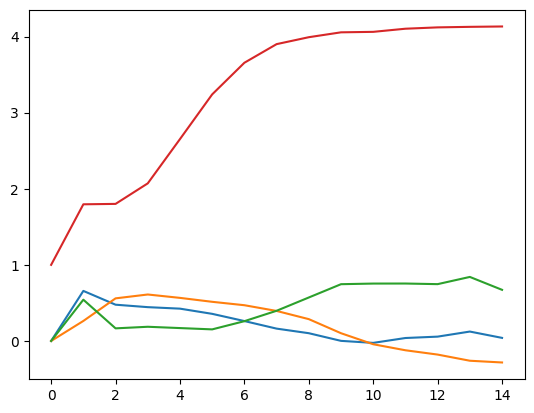

: 

In [ ]:
plot([prob_shine.ravel_θ(h["θ"]) for h in result_shine.history]);

In [ ]:
result_id.H

DeviceArray([[  1.618,   1.911,   1.113,  -0.003],
             [  0.541,   1.093,   1.905,  -0.006],
             [  0.599,   1.531,   3.051,  -0.001],
             [173.746, 367.491, 757.784,  95.078]], dtype=float64)

: 

In [ ]:
chain = np.hstack([mcmc.get_samples()["σw"], mcmc.get_samples()["prec_obs"][:,np.newaxis]])

: 

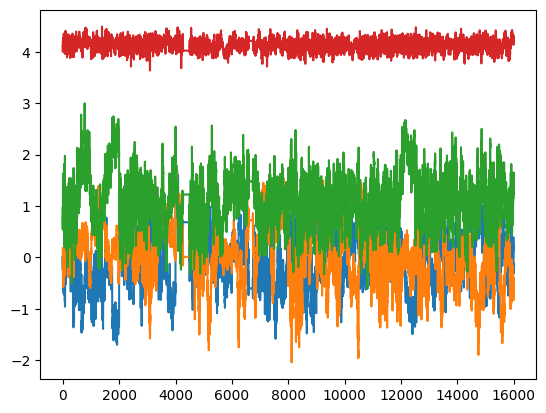

: 

In [ ]:
plot(log(chain));

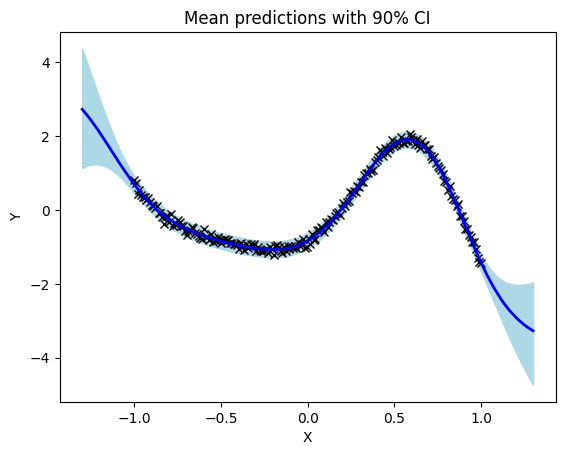

: 

In [ ]:
# helper function for prediction
def predict(model, rng_key, samples, X, D_H):
    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    # note that Y will be sampled in the model because we pass Y=None here
    model_trace = handlers.trace(model).get_trace(X=X, D_H=D_H)
    return model_trace["Y"]["value"]

samples = mcmc.get_samples()

# predict Y_test at inputs X_test
vmap_args = (
    samples,
    jnr.split(jnr.PRNGKey(0), mcmc.num_samples * mcmc.num_chains),
)
predictions = vmap(
    lambda samples, rng_key: predict(model, rng_key, samples, X_test, D_H)
)(*vmap_args)
predictions = predictions[..., 0]

# compute mean prediction and confidence interval around median
mean_prediction = jnp.mean(predictions, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

# make plots
fig, ax = plt.subplots()

# plot training data
ax.plot(X[:, 1], Y[:, 0], "kx")
# plot 90% confidence level of predictions
ax.fill_between(
    X_test[:, 1], percentiles[0, :], percentiles[1, :], color="lightblue"
)
# plot mean prediction
ax.plot(X_test[:, 1], mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI");

## Agreement

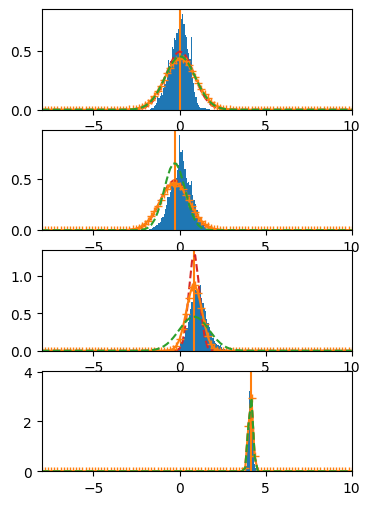

: 

In [ ]:
figure(figsize=(4,6))
for i in range(4):
    subplot(4, 1, i+1)
    
    hist(log(chain)[:,i], density=True, bins=50);
    xlim(-8, 10)

    axvline(prob_id.ravel_θ(result_id.θ)[i], c="C1")
    xs = linspace(*xlim(), 100)
    plot(xs, exp(dist.Normal(prob_shine.ravel_θ(result_shine.θ)[i], sqrt(result_shine.Σ[i,i])).log_prob(xs)), "C3--")
    plot(xs, exp(dist.Normal(prob_id.ravel_θ(result_id.θ)[i], sqrt(result_id.Σ[i,i])).log_prob(xs)), "C1-+")
    plot(xs, exp(dist.Normal(prob_fd.ravel_θ(result_fd.θ)[i], sqrt(result_fd.Σ[i,i])).log_prob(xs)), "C2--")

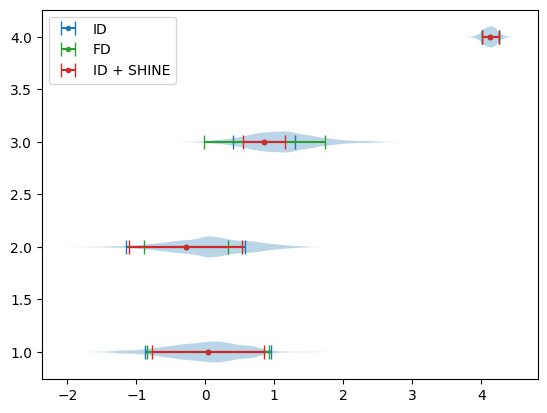

: 

In [ ]:
from cProfile import label


violinplot(log(chain), showextrema=False, vert=False, widths=0.2)#, quantiles=[[0.025,0.975]]*4)
errorbar(result_id.ravel(result_id.θ), range(1,5), xerr=sqrt(diag(result_id.Σ)), marker=".", capsize=5, ls="", c="C0", label='ID')
errorbar(result_fd.ravel(result_fd.θ), range(1,5), xerr=sqrt(diag(result_fd.Σ)), marker=".", capsize=5, ls="", c="C2", label='FD')
errorbar(result_shine.ravel(result_shine.θ), range(1,5), xerr=sqrt(diag(result_shine.Σ)), marker=".", capsize=5, ls="", c="C3", label='ID + SHINE')
plt.legend()

## Factor

In [ ]:
factor_speedup["bnn"] = [np.max(ncalls_chain_per_ess / ncalls_muse_per_ess_fd), np.max(ncalls_chain_per_ess / ncalls_muse_per_ess_id), np.max(ncalls_chain_per_ess / ncalls_muse_per_ess_shine)]
factor_speedup["bnn"]

[99.25917309955292, 153.9601964049502, 159.7639355946375]

: 

# Funnel

## Model

In [ ]:
def funnel(Nθ, Nz):
    jax.debug.callback(register_call)
    θ = numpyro.sample("θ", dist.Normal(0, 3), sample_shape=(Nθ,))
    z = numpyro.sample("z", dist.Normal(0, jnp.exp(θ/2)), sample_shape=(Nz,))
    x = numpyro.sample("x", dist.Normal(jnp.tanh(z), 1))
    return (x, z, θ)

In [ ]:
Nθ = 10
Nz = 500

In [ ]:
θ = jnp.zeros(Nθ)

In [ ]:
x = seed(condition(funnel, {"θ": θ}), jax.random.PRNGKey(0))(Nθ, Nz)[0]

## NUTS

In [ ]:
%%time
mcmc = MCMC(NUTS(condition(funnel, {"x":x})), num_warmup=100, num_samples=500, num_chains=32, progress_bar=False)
ncalls_nuts = count_calls(lambda: mcmc.run(jnr.PRNGKey(0), Nθ, Nz))[0]

In [ ]:
chains["funnel"] = chain = mcmc.get_samples()["θ"]

In [ ]:
ess = effective_sample_size(np.array(mcmc.get_samples(True)["θ"]))
ncalls_chain_per_ess = ncalls_nuts / ess
ncalls_chain_per_ess

## MUSE

In [ ]:
class NumpyroFunnelProblem(JaxMuseProblem):

    def __init__(self, model, *args, **kwargs):
        super().__init__(**kwargs)
        self.args = args
        self.x = model.data["x"]
        self.model_like = model
        self.model_prior = model # block(model.fn, lambda site: site["name"]!="θ")
        self.model_sample = model.fn


    def sample_x_z(self, key, θ):
        (x, z, θ) = seed(condition(self.model_sample, {"θ": θ}), key)(*self.args)
        return (x, z)

    def logLike(self, x, z, θ):
        return log_density(self.model_like, self.args, {}, {"x": x, "z": z, "θ": θ})[0]

    def logPrior(self, θ):
        with seed(rng_seed=0): # dummy seed
            model_trace = trace(condition(self.model_prior, {"θ": θ})).get_trace(*self.args)
        return jnp.sum(model_trace["θ"]["fn"].log_prob(model_trace["θ"]["value"]))


In [ ]:
(prob_shine, prob_id, prob_fd) = [
    NumpyroFunnelProblem(condition(funnel, {"x": x}), Nθ, Nz, implicit_diff=implicit_diff, use_shine=use_shine)
    for implicit_diff, use_shine in [
        (True, True),  # SHINE
        (True, False),  # ID
        (False, False),  # FD
    ]
]

In [ ]:
def solve(prob):
    z_tol = 1e-1
    nsims = 100
    θ_rtol = 1e-1
    result = MuseResult()
    prob.solve(θ_start=θ, rng=jnr.PRNGKey(4), z_tol=z_tol, nsims=nsims, θ_rtol=θ_rtol, result=result, progress=True, get_covariance=False)
    prob.get_J(result=result, nsims=nsims, progress=True, z_tol=z_tol)
    prob.get_H(result=result, nsims=nsims, progress=True, z_tol=z_tol)
    result.finalize(prob)
    return result
    
(ncalls_muse_shine, result_shine), (ncalls_muse_id, result_id), (ncalls_muse_fd, result_fd) = [count_calls(lambda: solve(prob)) for prob in [prob_shine, prob_id, prob_fd]]
results["funnel"] = result_id

In [ ]:
ncalls_muse_per_ess_id = ncalls_muse_id / len(result_id.s_MAP_sims)
ncalls_muse_per_ess_shine = ncalls_muse_shine / len(result_shine.s_MAP_sims)
ncalls_muse_per_ess_fd = ncalls_muse_fd / len(result_fd.s_MAP_sims)

In [ ]:
figure(figsize=(4,Nθ/2))
for i in range(Nθ):
    subplot(10, 1, i+1)
    axvline(θ[i], c="k")

    hist(mcmc.get_samples()["θ"][:,i], bins=40, density=True);
    xlim(-4, 7)

    axvline(result_id.θ[i], c="C1")
    xs = linspace(*xlim(), 100)
    plot(xs, exp(dist.Normal(result_id.θ[i], sqrt(result_id.Σ[i,i])).log_prob(xs)))

    # ylim(0, 1.5)

In [ ]:
violinplot(mcmc.get_samples()["θ"].T, showextrema=False, vert=False)#, quantiles=[[0.16,0.84]]*Nθ)#quantiles=[[0.025,0.975]]*Nθ)
errorbar(result_id.ravel(result_id.θ), range(1,Nθ+1), xerr=sqrt(diag(result_id.Σ)), marker=".", capsize=5, ls="", c="C0")
errorbar(result_shine.ravel(result_shine.θ), range(1,Nθ+1), xerr=sqrt(diag(result_shine.Σ)), marker=".", capsize=5, ls="", c="C3")

In [ ]:
factor_speedup["funnel"] = [np.max(ncalls_chain_per_ess / ncalls_muse_per_ess_fd), np.max(ncalls_chain_per_ess / ncalls_muse_per_ess_id), np.max(ncalls_chain_per_ess / ncalls_muse_per_ess_shine)]
factor_speedup["funnel"]

# PPCA

## Model

In [ ]:
N = 100
M = 5
D = 20

In [ ]:
def pPCA_ARD():
    jax.debug.callback(register_call)
    α = numpyro.sample("α", dist.InverseGamma(1.0, 1.0),           sample_shape=(D,)  )
    z = numpyro.sample("z", dist.Normal(0, 1),                     sample_shape=(D, N))
    w = numpyro.sample("w", dist.Normal(0, jnp.sqrt(α)),           sample_shape=(D,)  ).T
    x = numpyro.sample("x", dist.Normal(w @ z, 1),                 sample_shape=(M,)  )
    return x, (z, w), α

In [ ]:
θ = logspace(-2, 4, D, base=e)
θ

In [ ]:
with seed(rng_seed=0):
    x, (z, w), α = condition(pPCA_ARD, {"α": θ, "w": jnp.diag(jnp.sqrt(θ))})()

## NUTS

In [ ]:
%%time
mcmc = MCMC(NUTS(condition(pPCA_ARD, {"x":x})), num_warmup=100, num_samples=500, num_chains=32, progress_bar=False)
ncalls_nuts = count_calls(lambda: mcmc.run(jnr.PRNGKey(0)))[0]

In [ ]:
chains["ppca"] = mcmc.get_samples()["α"]

In [ ]:
ess = effective_sample_size(np.array(mcmc.get_samples(True)["α"]))
ncalls_chain_per_ess = ncalls_nuts / ess
ncalls_chain_per_ess

## MUSE

In [ ]:
class NumpyroPPCAProblem(JaxMuseProblem):

    def __init__(self, model, **kwargs):
        super().__init__(**kwargs)
        self.x = model.data["x"]
        self.model_like = model.fn
        self.model_prior = model # block(model.fn, lambda site: site["name"]!="θ")
        self.model_sample = model.fn
        
    def sample_x_z(self, key, logα):
        (x, z_w, _) = seed(condition(self.model_sample, {"α": jnp.exp(logα)}), key)()
        return (x, z_w)

    def logLike(self, x, z_w, logα):
        (z, w) = z_w
        # model_trace = trace(condition(self.model_like, {"α": jnp.exp(logα), "x": x, "z": z, "w": w})).get_trace()
        # return jnp.sum(jnp.array([jnp.sum(model_trace[k]["fn"].log_prob(model_trace[k]["value"])) for k in ["w"]]))
        return log_density(self.model_like, (), {}, {"x": x, "z": z, "w": w, "α": jnp.exp(logα)})[0]

    def z_MAP_guess_from_truth(self, x, z_w, _):
        (z, w) = z_w
        return z_w
        # return (0*z, jnp.eye(w.shape[1]))
    
    def logPrior(self, logα):
        with seed(rng_seed=0): # dummy seed
            model_trace = trace(condition(self.model_prior, {"α": jnp.exp(logα)})).get_trace()
        return jnp.sum(model_trace["α"]["fn"].log_prob(model_trace["α"]["value"])) #+ jnp.sum(logα)
    
#     def z_MAP_and_score(self, x, z_guess, θ, method=None, options=dict(), z_tol=None, θ_tol=None):

#         if z_tol is not None:
#             options = dict(gtol=z_tol, **options)
#         if method is None:
#             method = "l-bfgs-experimental-do-not-rely-on-this"

#         # opt = jaxopt.ScipyMinimize(
#         #     fun = lambda z_vec: -self.logLike(x, unravel(z_vec), θ),
#         #     method = "L-BFGS-B",
#         #     **options
#         # )
#         # soln = opt.run(ravel(z_guess))
#         # zMAP = unravel(soln.params)

#         # h = jnp.sqrt(jnp.diag(jax.hessian(lambda z_vec: -self.logLike(x, unravel(z_vec), θ))(ravel(z_guess))))
#         h = 1
        
#         for i in range(1):
#             soln = minimize(
#                 lambda z_vec: -self.logLike(x, self.unravel_z(z_vec / h), θ), 
#                 self.ravel_z(z_guess) * h, 
#                 method = method,
#                 options = options
#             )
#             z_guess = soln.x
        
#         zMAP = self.unravel_z(soln.x / h)
        
#         gradθ = self.val_gradz_gradθ_logLike(x, zMAP, θ)[2]

#         return ScoreAndMAP(gradθ, gradθ, zMAP, soln)

In [ ]:
(prob_shine, prob_id, prob_fd) = [
    NumpyroPPCAProblem(condition(pPCA_ARD, {"x": x}), implicit_diff=implicit_diff, implicit_diff_cgtol=1e-1, use_shine=use_shine)
    for implicit_diff, use_shine in [
        (True, True),  # SHINE
        (True, False),  # ID
        (False, False),  # FD
    ]
]

In [ ]:
def solve(prob):
    z_tol = 1e-1
    nsims = 100
    θ_rtol = 1e-1
    result = MuseResult()
    
    prob.solve(
        result=result, θ_start=jnp.zeros(D), α=1, 
        z0 = "prior",
        rng=jnr.PRNGKey(10), 
        z_tol=1e-1, θ_rtol=0,
        maxsteps=5,
        nsims=100,
        progress=True, get_covariance=False,
        save_MAP_history=False
    )
    
    prob.get_J(result=result, nsims=nsims, progress=True, z_tol=z_tol)
    prob.get_H(result=result, nsims=nsims, progress=True, z_tol=z_tol, use_median=True)
    result.finalize(prob)
    return result
    
(ncalls_muse_shine, result_shine), (ncalls_muse_id, result_id), (ncalls_muse_fd, result_fd) = [count_calls(lambda: solve(prob)) for prob in [prob_shine, prob_id, prob_fd]]

In [ ]:
results["ppca"] = result_id;

In [ ]:
ncalls_muse_per_ess_id = ncalls_muse_id / len(result_id.s_MAP_sims)
ncalls_muse_per_ess_shine = ncalls_muse_shine / len(result_shine.s_MAP_sims)
ncalls_muse_per_ess_fd = ncalls_muse_fd / len(result_fd.s_MAP_sims)

In [ ]:
factor_speedup["ppca"] = [np.max(ncalls_chain_per_ess / ncalls_muse_per_ess_fd), np.max(ncalls_chain_per_ess / ncalls_muse_per_ess_id), np.max(ncalls_chain_per_ess / ncalls_muse_per_ess_shine)]
factor_speedup["ppca"]

In [ ]:
violinplot(log(mcmc.get_samples()["α"]), showextrema=False, vert=False); 
errorbar(result_id.ravel(result_id.θ), range(1,D+1), xerr=sqrt(diag(result_id.Σ)), marker=".", capsize=5, ls="", c="C0");

### Check

In [ ]:
plot(([h["θ"] for h in result_id.history]));

In [ ]:
figure(figsize=(4,6))
for i in range(len(α)):
    subplot(len(α), 1, i+1)
    # axvline(log((α)[i]), c="k")
    hist(log(mcmc.get_samples()["α"])[:,i], density=True, bins=50);
    xlim(-8, 10)
    axvline((result_id.θ)[i], c="C1")
    xs = linspace(*xlim(), 100)
    plot(xs, exp(dist.Normal(result_id.θ[i], sqrt(result_id.Σ[i,i])).log_prob(xs)), "--")
    plot(xs, exp(dist.Normal(result_fd.θ[i], sqrt(result_fd.Σ[i,i])).log_prob(xs)), "--")    

# Plot

In [ ]:
fig = figure(figsize=(6,5))
gs = GridSpec(3, 3, figure=fig, hspace=0.5)
sca(fig.add_subplot(gs[:2, :]))

dx = 0.2

bar(arange(1,3) - dx, [1, 1], width=dx)
bar(arange(1,3),      [factor_speedup["funnel"][0], factor_speedup["bnn"][0]], width=dx)
bar(arange(1,3) + dx, [factor_speedup["funnel"][1], factor_speedup["bnn"][1]], width=dx)

legend(["HMC", "MUSE (FD)", "MUSE (ID)"], loc="upper left", frameon=True)

xticks([1, 2, 3])
gca().set_xticklabels(["Funnel", "BNN", "PPCA\n(right axis)"])
xlim(0.6, 3.4)

ylabel("speedup relative to HMC", fontsize=12)
ylim(0, 410)
axvline(2.5, c="k", ls=":")

twinx()
ylabel("speedup relative to HMC", fontsize=12)

bar(3 - dx, 1, width=dx)
bar(3,      factor_speedup["ppca"][0], width=dx)
bar(3 + dx, factor_speedup["ppca"][1], width=dx)
ylim(0,6.5)

alpha = 0.5

sca(fig.add_subplot(gs[2, 0]))
parts = violinplot(chains["funnel"].T, showextrema=False, vert=False, widths=0.5)
for pc in parts['bodies']: pc.set_alpha(alpha)
errorbar(results["funnel"].ravel(results["funnel"].θ), range(1,results["funnel"].Σ.shape[0]+1), xerr=sqrt(diag(results["funnel"].Σ)), marker=".", capsize=2, ls="", c="C0")
yticks([])
xlabel(r"$\theta$")
       
sca(fig.add_subplot(gs[2, 1]))
parts = violinplot(log(chains["bnn"]), showextrema=False, vert=False, widths=0.3)
for pc in parts['bodies']: pc.set_alpha(alpha)
errorbar(results["bnn"].ravel(results["bnn"].θ), range(1,results["bnn"].Σ.shape[0]+1), xerr=sqrt(diag(results["bnn"].Σ)), marker=".", capsize=2, ls="", c="C0")
yticks([])
xlabel(r"$\log[\sigma,\tau]$")

sca(fig.add_subplot(gs[2, 2]))
parts = violinplot(log(chains["ppca"]), showextrema=False, vert=False, widths=0.8); 
for pc in parts['bodies']: pc.set_alpha(alpha)
errorbar(results["ppca"].ravel(results["ppca"].θ), range(1,results["ppca"].Σ.shape[0]+1), xerr=sqrt(diag(results["ppca"].Σ)), marker=".", capsize=2, ls="", c="C0");
yticks([])
xlabel(r"$\log\alpha$")

savefig("toyproblems.pdf", bbox_inches="tight")

In [ ]:
factor_speedup["funnel"][0], factor_speedup["bnn"][0], factor_speedup["ppca"][0]

In [ ]:
factor_speedup["funnel"][1], factor_speedup["bnn"][1], factor_speedup["ppca"][1]